In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from cnn_functions import format_coord as cf
from skimage import morphology as morph
import skimage as sk
import scipy as sp
from scipy import ndimage
from skimage import feature
from cnn_functions import get_image
import glob, os, fnmatch
from skimage import io
import time
import random

Using Theano backend.


In [14]:
direc_name = '/home/amandap/data/deepCellData/sets'
file_name_save = os.path.join('/home/amandap/data/deepCellData/training_data_npz/', 'AT22LA_all_61x61.npz')
patch_name_save = os.path.join(direc_name, 'patch_rois/')
training_direcs = ["m05s01set00", "m05s01set02", "m05s01set04", "m05s01set06", 
                   "m05s07set01", "m05s07set03", "m05s07set05", "m05s07set07", 
                   "m54s03set01", "m54s03set03", "m54s03set05", "m54s03set07", 
                   "m54s07set00", "m54s07set02", "m54s07set04", "m54s07set06"
                  ] 
channel_names = ["img", "nuc"]

print(direc_name)
print(patch_name_save)

/home/amandap/data/deepCellData/sets
/home/amandap/data/deepCellData/sets/patch_rois/


In [15]:
num_of_features = 2
feature_names=["cyto", "edge"]
dil_radius = 1
print(feature_names)

['cyto', 'edge']


/home/amandap/anaconda3/envs/deepcell_covert_env/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/home/amandap/anaconda3/envs/deepcell_covert_env/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


<IPython.core.display.Javascript object>


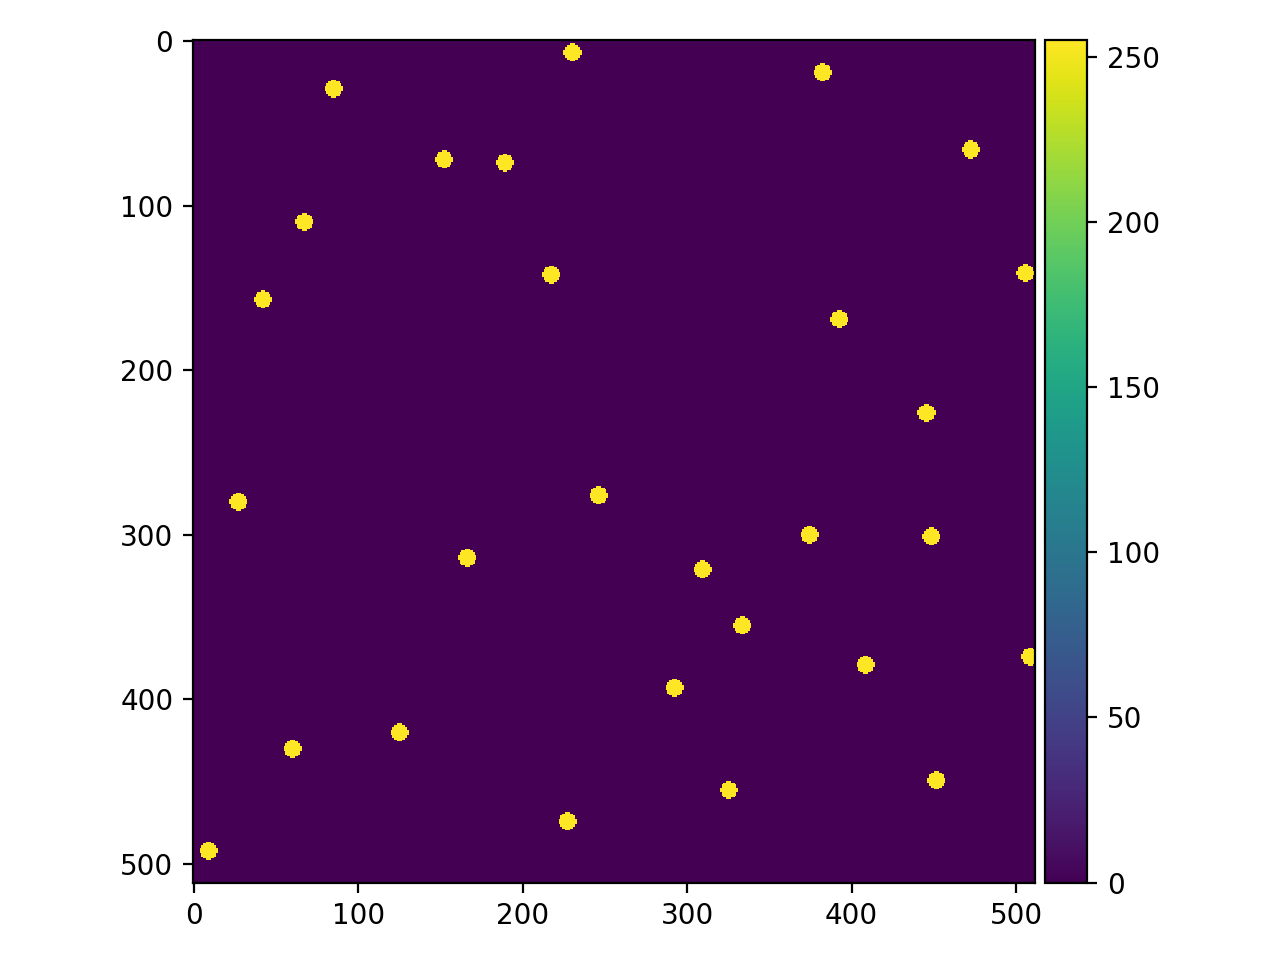

In [16]:
num_direcs = len(training_direcs)
num_channels = len(channel_names)

imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the feature masks
channels = np.zeros((num_direcs, num_channels, image_size_x, image_size_y), dtype='float32')
feature_mask = np.zeros((num_direcs, num_of_features + 1, image_size_x, image_size_y))

io.imshow(img_temp)

In [ ]:
t=time.time()
# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

        # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file)
                
                
        # Normalize the images
                if channel == 'img':
                    p50 = np.percentile(channel_img, 50)
                    channel_img /= p50
                    print(p50)
                    avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                    channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size
                else:
                    channel_img /= np.amax(channel_img)
                    print(np.amax(channel_img))
                      
                channels[direc_counter,channel_counter,:,:] = channel_img
                channel_counter += 1
                print(channel_counter)
                
                
    # Load feature mask
    for j in xrange(num_of_features):
        feat = feature_names[j]
        for img in imglist:
            if fnmatch.fnmatch(img, r'*' + feat + r'*'):
                feature_file = os.path.join(direc_name, direc, img)
                feature_img = get_image(feature_file)
                #normalize to 1
                if np.sum(feature_img) > 0:
                    feature_img /= np.amax(feature_img)

                if feat == "edge":
                    strel = sk.morphology.disk(dil_radius)
                    feature_img = sk.morphology.binary_dilation(feature_img, 
                                                                selem = strel)
                feature_mask[direc_counter,j,:,:] = feature_img

    # Thin the augmented edges by subtracting the interior features.
    for j in xrange(num_of_features):
        feat=feature_names[j]
        if feat == "edge":
            for k in xrange(num_of_features):
                if feat == "cyto":
                    feature_mask[direc_counter,j,:,:] -= feature_mask[direc_counter,k,:,:]
            feature_mask[direc_counter,j,:,:] = feature_mask[direc_counter,j,:,:] > 0

    # Compute the mask for the background
    feature_mask_sum = np.sum(feature_mask[direc_counter,:,:,:], axis = 0)
    feature_mask[direc_counter,num_of_features,:,:] = 1 - feature_mask_sum

    
    direc_counter += 1
print(time.time()-t, ' seconds elapsed')

In [17]:
image.extract_patches_2d(image, patch_size, max_patches=None, random_state=None)

NameError: name 'patch_size' is not defined